In [2]:
# Import libraries
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import seaborn as sns

import matplotlib.pyplot as plt

In [3]:
# Specify filepaths and filenames.
filepath = '/home/jovyan/ML_MB_Norway_data/'
filename = '2023-06-01_stake_mb_norway_cleaned_ids_latlon_wattributes.csv'

In [4]:
# Load data.
data = pd.read_csv(filepath + filename)

data
data.columns

Index(['Unnamed: 0', 'RGIID', 'GLIMSID', 'BREID', 'utm_zone',
       'utm_east_approx', 'utm_north_approx', 'altitude_approx',
       'location_description', 'location_id', 'stake_no', 'altitude',
       'utm_east', 'utm_north', 'balance_winter', 'balance_summer',
       'balance_netto', 'dt_prev_year_min_date', 'dt_curr_year_max_date',
       'dt_curr_year_min_date', 'stake_remark', 'flag_correction',
       'approx_loc', 'approx_altitude', 'diff_north', 'diff_east',
       'diff_altitude', 'diff_netto', 'lat', 'lon', 'lat_approx', 'lon_approx',
       'topo', 'aspect', 'slope', 'slope_factor', 'dis_from_border'],
      dtype='object')

In [5]:
data.shape

(4044, 37)

In [7]:
# Get stats

#%% Stats

# Stats for quality of approximate locations and altitudes:
mean_loc_diff_east = data.loc[data['approx_loc'] != 'Y', 'diff_east'].mean()
min_loc_diff_east = data.loc[data['approx_loc'] != 'Y', 'diff_east'].min()
max_loc_diff_east = data.loc[data['approx_loc'] != 'Y', 'diff_east'].max()
sd_loc_diff_east = data.loc[data['approx_loc'] != 'Y', 'diff_east'].std()

mean_loc_diff_north = data.loc[data['approx_loc'] != 'Y', 'diff_north'].mean()
min_loc_diff_north = data.loc[data['approx_loc'] != 'Y', 'diff_north'].min()
max_loc_diff_north = data.loc[data['approx_loc'] != 'Y', 'diff_north'].max()
sd_loc_diff_north = data.loc[data['approx_loc'] != 'Y', 'diff_north'].std()

mean_altitude_diff = data.loc[data['approx_altitude'] != 'Y', 'diff_altitude'].mean()
min_altitude_diff = data.loc[data['approx_altitude'] != 'Y', 'diff_altitude'].min()
max_altitude_diff = data.loc[data['approx_altitude'] != 'Y', 'diff_altitude'].max()
sd_altitude_diff = data.loc[data['approx_altitude'] != 'Y', 'diff_altitude'].std()

# Number of instances of winter balance: 3680
no_winter = data['balance_winter'].notna().sum()

# Number of instances of summer balance: 3805
no_summer = data['balance_summer'].notna().sum()

# Number of instances of annual balance: 3839
no_annual = data['balance_netto'].notna().sum()

# Number of points with exact coordinates: 3717 of 4046
no_exact_locs = (data['approx_loc'].values == 'N').sum()

# Number of points with approximate coordinates: 329 of 4046
no_approx_locs = (data['approx_loc'].values == 'Y').sum()
    
# Number of points with exact altitude: 4009
no_exact_alt = (data['approx_altitude'].values == 'N').sum()

# Number of points with exact altitude: 37
no_approx_alt = (data['approx_altitude'].values == 'Y').sum()

# Number of points w/o exact coordinates or altitude: 32
no_approx_both = ((data['approx_altitude'].values == 'Y') & (data['approx_loc'].values == 'Y')).sum()
   
# Number of unique glacier IDs: 32
no_unique_id = data['BREID'].nunique()    

# List of unique glacier IDs:
list_unique_id = list(data['BREID'].unique())

# Unique glacier IDs with number of entries per ID.
# Index is glacier ID and column is number of entries per glacier ID.
len_rec_per_id = data['BREID'].value_counts().to_frame()    

In [8]:
# Summary
print('Total number of points: ' + str(data.shape[0]))
print('Number of unique ids: ' + str(no_unique_id))
print('Number of annual mass balance: ' + str(no_annual))
print('Number of winter mass balance: ' + str(no_winter))
print('Number of summer mass balance: ' + str(no_summer))

Total number of points: 4044
Number of unique ids: 32
Number of annual mass balance: 3839
Number of winter mass balance: 3680
Number of summer mass balance: 3803


In [11]:
# Count number of instances of winter, summer and annual mass balance for each glacier
data_pergla = data.groupby('BREID').count()
data_pergla[['balance_winter', 'balance_summer','balance_netto']]

#TO-DO: Plot as circles on map


,balance_winter,balance_summer,balance_netto
BREID,,,
54,174,172,189
596,122,124,122
675,174,194,178
703,30,31,30
941,71,70,70
1092,19,18,18
1094,222,231,222
1135,29,29,56
1144,70,77,70


In [12]:
# Make column 'Year' from column 'dt_curr_year_min_date'
data['dt_curr_year_min_date']

0       07.11.2013 00:00
1       24.09.2014 00:00
2       23.09.2015 00:00
3       22.09.2016 00:00
4       29.09.2017 00:00
              ...       
4039    12.10.2012 00:00
4040    24.09.2013 00:00
4041    14.10.2015 00:00
4042    06.10.2016 00:00
4043    09.10.2017 00:00
Name: dt_curr_year_min_date, Length: 4044, dtype: object

In [13]:
data['year']=pd.to_datetime(data['dt_curr_year_min_date'].astype('string'), format="%d.%m.%Y %H:%M")


In [14]:
data['year']

0      2013-11-07
1      2014-09-24
2      2015-09-23
3      2016-09-22
4      2017-09-29
          ...    
4039   2012-10-12
4040   2013-09-24
4041   2015-10-14
4042   2016-10-06
4043   2017-10-09
Name: year, Length: 4044, dtype: datetime64[ns]

In [15]:
# Get year from date and convert to integer
#data['year'] = data['year'].dt.strftime('%Y')
data['year'] = data.year.dt.year.astype('Int64')

<Figure size 640x480 with 0 Axes>

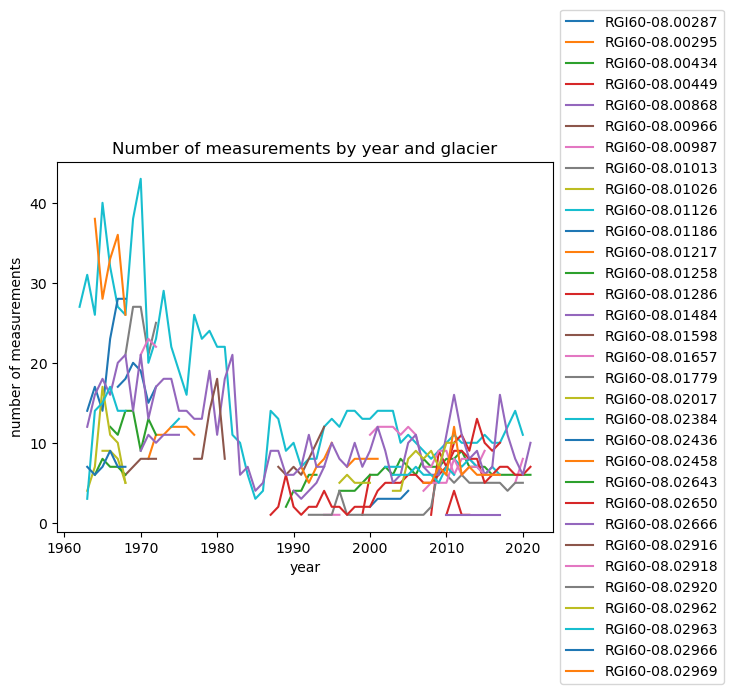

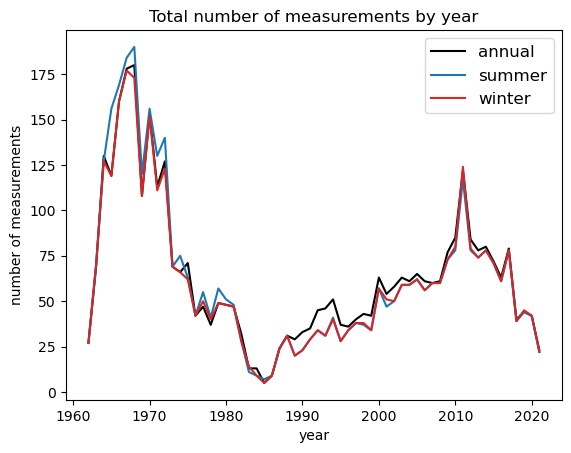

In [19]:
# Plot number of measurements by year, RGIID and type of measurement

# Plot number of measurements per glacier
plt.figure()
data.groupby(['year', "RGIID"]).size().unstack().plot()
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title('Number of measurements by year and glacier')
plt.ylabel('number of measurements')
plt.show()

data_netto = data[~data['balance_netto'].isnull()]
data_summer = data[~data['balance_summer'].isnull()]
data_winter = data[~data['balance_winter'].isnull()]

# Plot number of measurements per type of measurement
plt.figure()
data_netto.groupby(['year']).size().plot(color='k', legend='annual')
data_summer.groupby(['year']).size().plot(color='C0', legend='summer')
data_winter.groupby(['year']).size().plot(color='C3', legend='winter')
plt.title('Total number of measurements by year')
plt.ylabel('number of measurements')
plt.legend(['annual', 'summer', 'winter'], prop={'size': 12})
plt.show()

#data_summer.groupby(['year']).size().plot(color='k')
#plt.title('Total number of annual mb measurements by year')
#plt.show()

#data[['balance_summer','year']].groupby(['year']).size().plot(color='k')
#plt.title('Total number of annual mb measurements by year')
#plt.show()

In [21]:
data['RGIID'].unique().size
#np.arange(0,32)

32

In [22]:
data.groupby(["RGIID"])['lat'].mean()
data.groupby(["RGIID"])['lon'].mean()

RGIID
RGI60-08.00287    14.038821
RGI60-08.00295    13.641220
RGI60-08.00434     7.069515
RGI60-08.00449     8.444969
RGI60-08.00868     8.351151
RGI60-08.00966     8.467438
RGI60-08.00987     8.598833
RGI60-08.01013     8.503294
RGI60-08.01026    17.996249
RGI60-08.01126     7.126065
RGI60-08.01186     7.269918
RGI60-08.01217     7.682091
RGI60-08.01258    21.741502
RGI60-08.01286     7.364359
RGI60-08.01484    14.441205
RGI60-08.01598    13.760197
RGI60-08.01657    13.854210
RGI60-08.01779     7.385452
RGI60-08.02017     6.554746
RGI60-08.02384    16.046632
RGI60-08.02436    17.857556
RGI60-08.02458    17.919727
RGI60-08.02643     6.443590
RGI60-08.02650     5.679472
RGI60-08.02666     5.647653
RGI60-08.02916     6.321357
RGI60-08.02918     6.302102
RGI60-08.02920     6.262480
RGI60-08.02962     6.364450
RGI60-08.02963     6.395458
RGI60-08.02966     6.447582
RGI60-08.02969     6.347994
Name: lon, dtype: float64

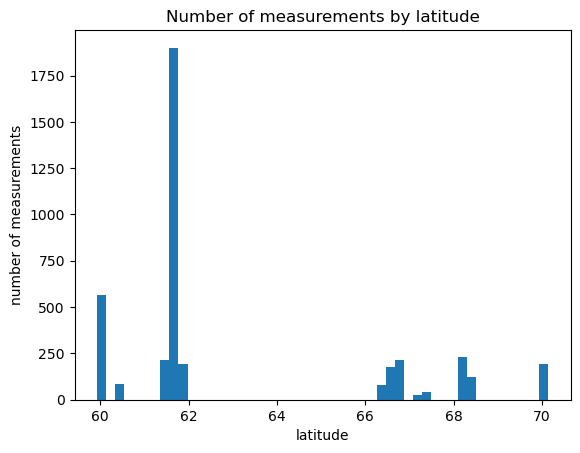

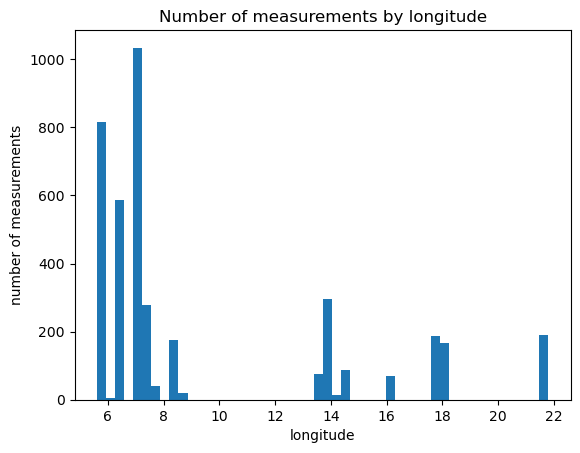

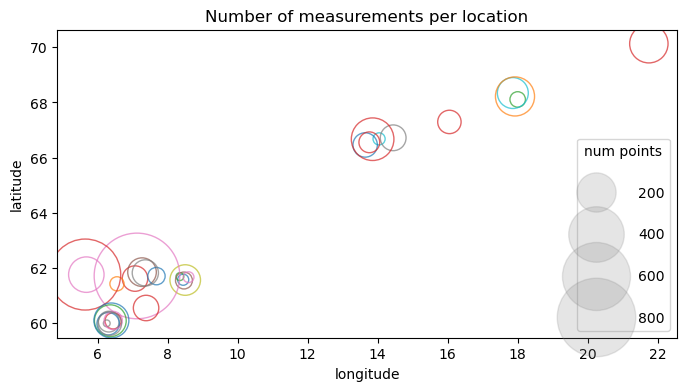

In [23]:
# Plot number of measurements by geographical location

# By latitude
plt.figure()
data['lat'].plot.hist(bins=50)
plt.title('Number of measurements by latitude')
plt.ylabel('number of measurements')
plt.xlabel('latitude')
plt.show()

# By longitude
plt.figure()
data['lon'].plot.hist(bins=50)
plt.title('Number of measurements by longitude')
plt.ylabel('number of measurements')
plt.xlabel('longitude')
plt.show()

# By latitude and longitude
colors = np.random.rand(data['RGIID'].unique().size)
c = plt.cm.tab10(colors)

plt.figure(figsize=(8,4))
#labels = list(data['RGIID'].unique())
sc=plt.scatter(x=data.groupby(["RGIID"])['lon'].mean().values, 
               y=data.groupby(["RGIID"])['lat'].mean().values, 
               s=data.groupby(["RGIID"]).size().values*4,
               facecolors='None', edgecolors=c, lw=1, alpha=0.7)#alpha=0.5)#, markerfacecolor="None");#* 200);
#data_netto['lat'].plot.hist(bins=50)
handles, labels = sc.legend_elements(prop="sizes", alpha=0.2, num=5, color='grey')#, fill=None)     
labels = ["200", "400", "600", "800"]     
legend = plt.legend(handles, labels, loc="lower right", title="num points",labelspacing=2, handletextpad=2)
#plt.legend(*sc.legend_elements("sizes", num=6))
plt.title('Number of measurements per location')
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.show()

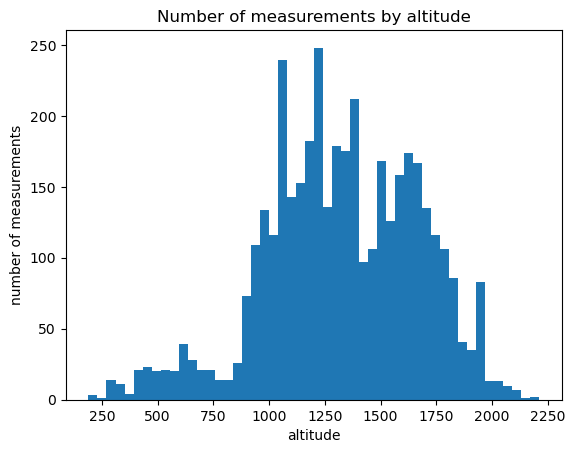

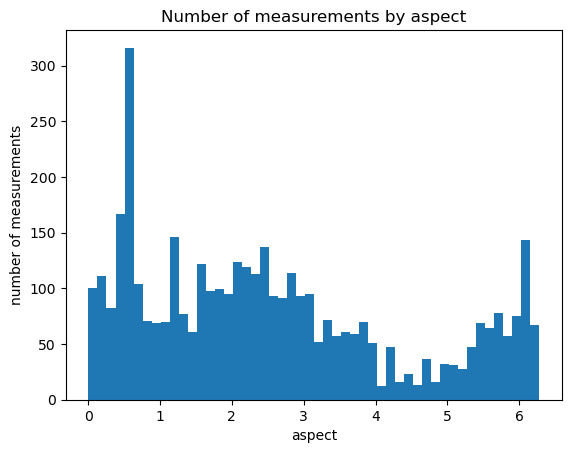

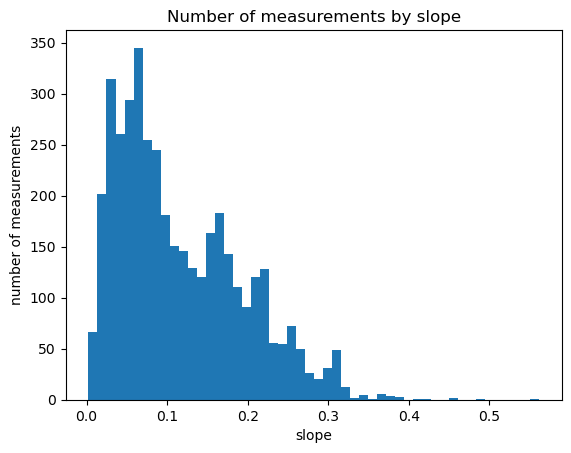

In [24]:
# Number of measurements by topography

plt.figure()
data['altitude'].plot.hist(bins=50)
plt.title('Number of measurements by altitude')
plt.ylabel('number of measurements')
plt.xlabel('altitude')
plt.show()

plt.figure()
data['aspect'].plot.hist(bins=50)
plt.title('Number of measurements by aspect')
plt.ylabel('number of measurements')
plt.xlabel('aspect')
plt.show()

plt.figure()
data['slope'].plot.hist(bins=50)
plt.title('Number of measurements by slope')
plt.ylabel('number of measurements')
plt.xlabel('slope')
plt.show()

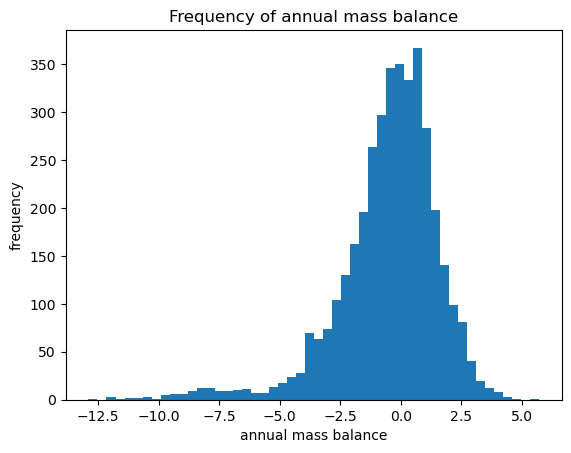

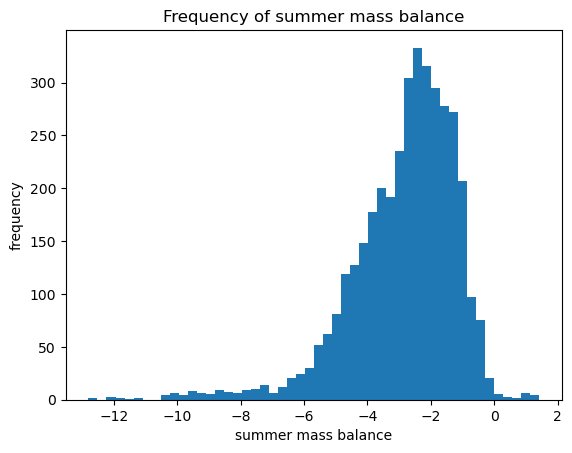

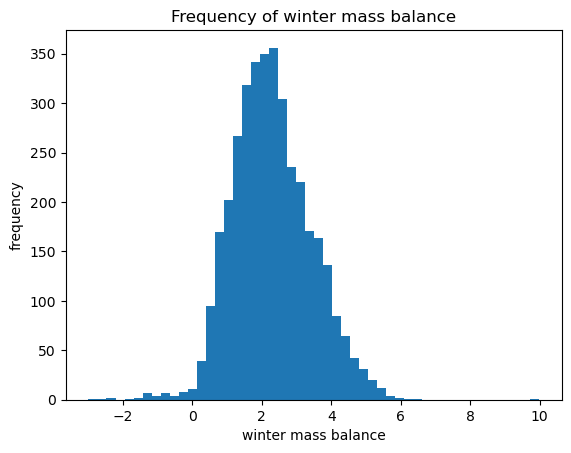

In [25]:
# Number of measurements by mass balance

plt.figure()
data['balance_netto'].plot.hist(bins=50)
plt.title('Frequency of annual mass balance')
plt.ylabel('frequency')
plt.xlabel('annual mass balance')
plt.show()

plt.figure()
data['balance_summer'].plot.hist(bins=50)
plt.title('Frequency of summer mass balance')
plt.ylabel('frequency')
plt.xlabel('summer mass balance')
plt.show()

plt.figure()
data['balance_winter'].plot.hist(bins=50)
plt.title('Frequency of winter mass balance')
plt.ylabel('frequency')
plt.xlabel('winter mass balance')
plt.show()

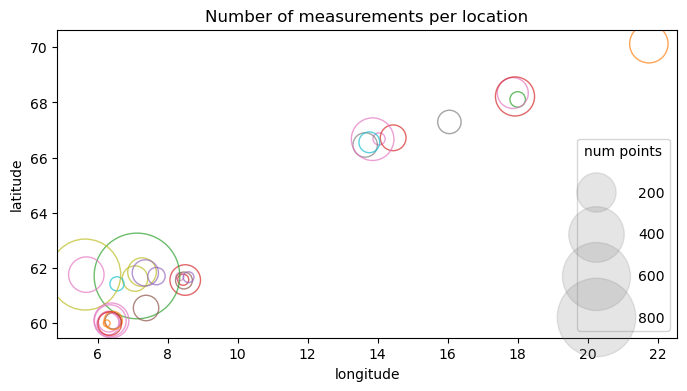

In [26]:
# By latitude and longitude
colors = np.random.rand(data['RGIID'].unique().size)
c = plt.cm.tab10(colors)

plt.figure(figsize=(8,4))
#labels = list(data['RGIID'].unique())
sc=plt.scatter(x=data.groupby(["RGIID"])['lon'].mean().values, 
               y=data.groupby(["RGIID"])['lat'].mean().values, 
               s=data.groupby(["RGIID"]).size().values*4,
               facecolors='None', edgecolors=c, lw=1, alpha=0.7)#alpha=0.5)#, markerfacecolor="None");#* 200);
#data_netto['lat'].plot.hist(bins=50)
handles, labels = sc.legend_elements(prop="sizes", alpha=0.2, num=5, color='grey')#, fill=None)     
labels = ["200", "400", "600", "800"]     
legend = plt.legend(handles, labels, loc="lower right", title="num points",labelspacing=2, handletextpad=2)
#plt.legend(*sc.legend_elements("sizes", num=6))
plt.title('Number of measurements per location')
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.show()

<Axes: >

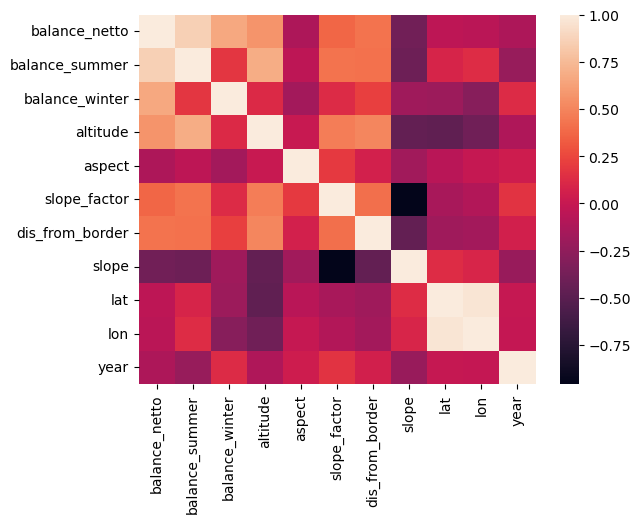

In [27]:
#Plot correlations
columns=['balance_netto','balance_summer','balance_winter','altitude','aspect',
         'slope_factor', 'dis_from_border','slope','lat','lon','year']
corr = data[columns].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

Negative correlation between annual/summer balance and slope (higher slope = more positive mb?).
Negative correlation between altitude and slope (higher altitude = lower slope)

Lower elevations have steeper slopes - Nigardsbreen?

In [29]:
data['aspect'].min()

0.0032726230565458

In [30]:
data['aspect'].max()

6.279065608978272